# Project 1: Milestone 2 - White Paper (Code)
### DSC680-T301 Applied Data Science
### Joshua Greenert
### 3/27/2023

## Data Preparation

In [1]:
# Set some required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pull in the data.
df_housing = pd.read_csv('Housing.csv')
df_hpi = pd.read_csv('HPI_master.csv')
df_sale_prices_states = pd.read_csv('Sale_Prices_State.csv')

df_state_stats = pd.read_excel('state_statistics_for_download.xls')

In [2]:
# Fix the state stats dataframe.
import datetime

# Correct the row headers for the state stats.
df_state_stats.columns = df_state_stats.iloc[3]

#remove first row from DataFrame
df_state_stats = df_state_stats[4:]

# Remove all values of US from the State column
df_state_stats = df_state_stats[df_state_stats['State'] != 'US']

# Split the Year-Quarter column into Year and Quarter columns
df_state_stats[['Year', 'Quarter']] = df_state_stats['Year-Quarter'].str.split('Q', expand=True)

# Remove the Year-Quarter column
df_state_stats.drop('Year-Quarter', axis=1, inplace=True)

# Show the head to confirm working
df_state_stats.head(3)

3,State,Average Price,Median Price,Year,Quarter
46,AK,159887,148406,2000,1
47,AK,166115,153989,2000,2
48,AK,166536,154215,2000,3


In [3]:
# Fix the area codes so that they are strings and have 0's at the beginning if the number is less than 5 digits.
for index, row in df_housing.iterrows():
    if(len(str(row['area'])) < 5):
        zipCode = "0" + str(row['area'])
        df_housing.at[index,'area'] = zipCode
    else:
        df_housing.at[index,'area'] = str(row['area'])
        
df_housing.head(3)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,07420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,08960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,09960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished


In [4]:
# Remove all rows with level that is not equal to state.
df_hpi = df_hpi[df_hpi['level'] == 'State']

# Remove all the periods not equal to 1
df_hpi = df_hpi[df_hpi['period'] == 1]

# Update the year to be a date; otherwise visuals won't work right.
for index, row in df_hpi.iterrows():
    year = int(row['yr'])
    date = datetime.date(year, 1, 1)
    df_hpi.at[index,'yr'] = date
    
# filter out any rows where hpi_flavor is not equal to all-transactions, and traditional data for hpi-type
df_hpi = df_hpi[df_hpi['hpi_flavor'] == "all-transactions"]
df_hpi = df_hpi[df_hpi['hpi_type'] == "traditional"]

# Drop all columns not needed
df_hpi = df_hpi.drop(['period', 'index_sa', 'frequency', 'level', 'hpi_flavor','hpi_type'], axis = 1)

# Show the head to confirm working
df_hpi.head(3)

,place_name,place_id,yr,index_nsa
67915,Alaska,AK,1975-01-01,62.05
67919,Alaska,AK,1976-01-01,71.34
67923,Alaska,AK,1977-01-01,78.24


In [5]:
# Remove all columns besides the state name and most recent pricing column with all values.
df_sale_prices_states = df_sale_prices_states.loc[:, ['RegionName', '2020-02']]

# Create a dict to map over.
state_abbr = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# create new column with state abbreviations
df_sale_prices_states['State'] = df_sale_prices_states['RegionName'].map(state_abbr)

df_sale_prices_states.head(3)

,RegionName,2020-02,State
0,California,524400,CA
1,Texas,239900,TX
2,New York,324800,NY


## Build Models: Random Forest Regression

In [9]:
# Let's attempt a model based on the Random Forest Regression now that we've seen how far away linear regression is.
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Make a copy of the state stats dataframe (just in case we want to use it later)
df_state_stats_copy = df_state_stats.copy()

# Split the data into training and testing sets
X = df_state_stats_copy[['State', 'Year', 'Quarter']]  # Features
y = df_state_stats_copy['Median Price']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode the 'State' column
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train[['State']])
X_train_enc = enc.transform(X_train[['State']]).toarray()
X_test_enc = enc.transform(X_test[['State']]).toarray()
X_train = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(X_train_enc)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(X_test_enc)], axis=1)
X_train = X_train.drop(['State'], axis=1)
X_test = X_test.drop(['State'], axis=1)

# Create a random forest regression model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Predict on the test data
y_pred = rf.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 107796653.33568087


As a model for making predictions over future housing prices, Random Forest Regression doesn't make predictions on new data well.  As we can see from the mean sqaure error, the amount of a future prediction has the potential to be off by 100 million, which is greater than any price within the dataset.  Moreover, after researching this model type a bit further, I've learned that this model is supposed to be used on similar data that matches the current data to make predictions, and therefore makes it incompatible for the current project.

## Build Models: Linear Regression

In [10]:
# Let's attempt a model based on linear regression using the hpi data
from sklearn.linear_model import LinearRegression

# Extract the year from the yr column
df_hpi["Year"] = pd.to_datetime(df_hpi["yr"]).dt.year

# Convert the State column to one-hot encoding
df_hpi = pd.concat([df_hpi, pd.get_dummies(df_hpi["place_id"])], axis=1)

# Define the input features (all columns except Year-Quarter and Price)
X = df_hpi.drop(["yr", "index_nsa", "place_id", "place_name"], axis=1)

# Define the target variable (index_nsa)
y = df_hpi["index_nsa"]

# Split the data into training and testing sets
X_train = X[X["Year"] < 2015]
y_train = y[X["Year"] < 2015]
X_test = X[X["Year"] >= 2015]
y_test = y[X["Year"] >= 2015]

# Fit the model
model = LinearRegression().fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 13714.800694736376


Linear Regression is not a wise choice for time series data, but I wanted to see how close the predictions could be with this model in comparison to the last one.  As we can see from the Mean Squared Error (MSE), the model is far away from anything near an accurate prediction.  If the hpi index is based on a 100 point value, then being greater than 13,000 is too far away to ever be valuable for future home values and estimations.

## Build Models: ARIMA (Time Series)

In [13]:
# Let's attempt a model based on ARIMA which is more catered towards these values.
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Create a copy of the dataframe to be able to use it later as needed.
df_hpi_copy = df_hpi.copy()

# Set the index to the year column
df_hpi_copy['yr'] = pd.to_datetime(df_hpi_copy['yr'])
df_hpi_copy.set_index('yr', inplace=True)

# Define the states to make predictions for
states = df_hpi_copy['place_id'].unique()

# Set up an empty dataframe to hold the predictions
predictions_df = pd.DataFrame()

# Loop through each state and make a prediction for 2020-2030
for state in states:
    # Get the data for the current state
    state_df = df_hpi_copy[df_hpi_copy['place_id'] == state]
    
    # Split the data into training and testing sets
    train = state_df.loc[:'2019']
    test = state_df.loc['2020':]
    
    # Define the ARIMA model 
    model = sm.tsa.statespace.SARIMAX(train['index_nsa'], order=(1,1,1), trend='c', seasonal_order=(1, 2, 2, 12))
    
    # Fit the model
    results = model.fit()
    
    # Make a forecast for the next 10 years
    forecast = results.get_forecast(steps=11)
    
    # Extract the predicted values
    predicted_values = forecast.predicted_mean
    
    # Add the predicted values to the predictions dataframe
    predictions_df[state] = predicted_values
    
# Add the year column to the predictions dataframe
predictions_df['year'] = pd.date_range(start='2022-01-01', periods=11, freq='Y')

# Set the year column as the index
predictions_df.set_index('year', inplace=True)

# Rename the columns to the state abbreviations
predictions_df.columns = states

In [14]:
# Show the predictions 
predictions_df.head(11)

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
year,,,,,,,,,,,,,,,,,,,,,
2022-12-31,333.723743,327.838643,272.959475,427.476367,580.842910,588.600322,381.379350,866.789646,442.265456,445.307342,...,391.405308,399.576618,352.847791,487.693357,456.899932,463.033722,647.801603,357.045474,201.862324,307.023785
2023-12-31,328.428849,327.325954,260.121203,335.809330,451.864253,604.797503,328.393750,814.405199,393.483497,353.698209,...,396.900547,391.926453,364.029455,433.389411,411.672758,424.579407,600.272227,339.158895,171.377650,273.340220
2024-12-31,337.445628,303.389672,221.884736,254.016228,407.172415,595.162161,265.757968,776.291736,328.403884,285.038785,...,375.762833,369.707009,367.935141,359.721825,359.152224,375.814899,539.213701,305.774856,121.215377,219.772451
2025-12-31,341.483527,283.211059,200.861268,207.730622,376.214706,599.237330,213.360621,766.218495,276.860537,250.013996,...,375.084616,356.030753,380.250819,317.898592,329.908986,342.655003,507.537145,287.567107,92.271627,185.856691
2026-12-31,373.787968,273.971749,192.695645,199.711690,356.751810,619.867983,174.682139,781.263376,234.133525,234.716919,...,375.544211,346.252782,406.667634,305.839401,306.265234,308.224455,489.214671,272.137901,75.852625,160.519566
2027-12-31,376.130448,274.479563,178.552791,229.582806,373.696358,652.234541,160.016796,814.193494,202.661779,242.754987,...,383.601458,353.251862,435.368926,312.314323,289.465583,291.691441,492.347148,262.338932,48.271303,140.819129
2028-12-31,437.156518,269.881692,167.219831,265.996734,427.193543,692.186582,139.926804,875.046788,184.518368,265.144027,...,385.334058,367.238216,462.442407,331.687066,274.338207,266.654218,499.082486,252.900927,35.891990,122.374809
2029-12-31,417.639419,276.922705,158.147110,279.743392,476.198876,739.814016,140.191590,916.828521,176.826416,288.429017,...,398.661639,396.680270,491.510056,344.315620,270.086949,252.062783,513.044393,268.185866,24.042778,106.483563
2030-12-31,432.417296,276.647662,151.683836,301.719867,541.967078,802.709474,130.859046,968.096436,157.406402,320.040074,...,412.153360,423.201648,519.089426,367.403079,255.806717,217.803921,546.255635,274.073403,9.614379,87.846368


The data listed here shows the HPI-predicted index per state per year.  Using California as a sample, we can see that the values take a sharp dive over the next few years, which matches the current movement as of 3/29/2023.  In a similar way to the 2008 housing crisis, it looks as though the predictions estimate a four-year period before the recovery.  To understand the data a bit more, let's graph the results so that we can see each state and it's respective prediction.

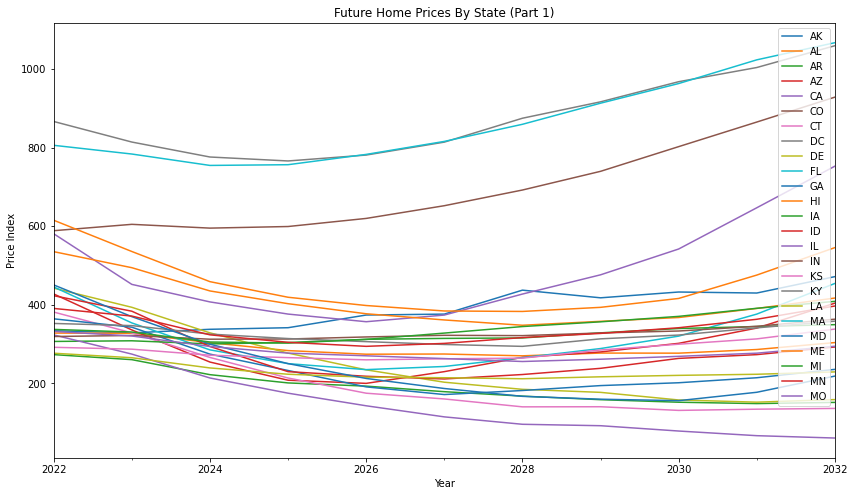

In [15]:
# Create a visualization of the data.
# Calculate the number of columns in the original dataframe
num_cols = len(predictions_df.columns)
half_cols = num_cols // 2

# Split the dataframe into two equal halves
df_predictions_1 = predictions_df.iloc[:, :half_cols]
df_predictions_2 = predictions_df.iloc[:, half_cols:]

df_predictions_1.plot(kind = 'line', figsize = (14, 8))

# Add the title and labels
plt.title('Future Home Prices By State (Part 1)')
plt.xlabel('Year')
plt.ylabel('Price Index')
plt.show()

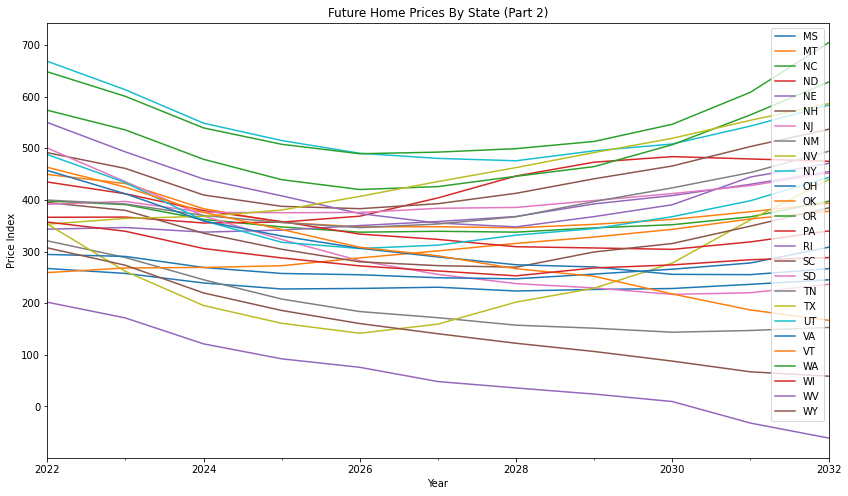

In [16]:
df_predictions_2.plot(kind = 'line', figsize = (14, 8))

# Add the title and labels
plt.title('Future Home Prices By State (Part 2)')
plt.xlabel('Year')
plt.ylabel('Price Index')
plt.show()

What we see in these graphs appears to match the initial assumption.  There are areas with high volatility that further express that volatility over the coming years.  The prediction estimates a recovery for the housing market roughly three to four years after the initial reduction period, similiar to previous data, while having some states be almost unaffected over the next seven years.  There are some outliers that show serious discordance with the rest of the data like WV and WY, but most states show a trend upwards similiar to the initial training data used.

## Build Models: LSTM (Time Series)

In [17]:
# Let's try an LSTM model for good measure.  It's usually best to handle this type of data.
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Create a copy of the dataframe to be able to use it later as needed.
df_hpi_copy = df_hpi.copy()

# Define the features and target variable
features = ['place_id', 'yr']
target = 'index_nsa'

# Create a separate dataframe for each state
state_dfs = {}
for state in df_hpi_copy['place_id'].unique():
    state_dfs[state] = df_hpi_copy[df_hpi_copy['place_id'] == state][[target]]
    
# Define the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    return model

# Train the LSTM model for each state
models = {}
for state, state_df in state_dfs.items():
    # Split the data into training and testing sets
    train_size = int(len(state_df) * 0.8)
    test_size = len(state_df) - train_size
    train_data = state_df.iloc[:train_size, :]
    test_data = state_df.iloc[train_size:, :]
    
    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    
    # Reshape the data for the LSTM model
    X_train = []
    y_train = []
    for i in range(10, train_size):
        X_train.append(train_scaled[i-10:i, 0])
        y_train.append(train_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    # Create and train the LSTM model
    model = create_lstm_model((X_train.shape[1], 1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32)
    models[state] = (model, scaler)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.3960
Epoch 2/100
1/1 [==============================] - 0s 13ms/step - loss: 0.3497
Epoch 3/100
1/1 [==============================] - 0s 12ms/step - loss: 0.3061
Epoch 4/100
1/1 [==============================] - 0s 12ms/step - loss: 0.2644
Epoch 5/100
1/1 [==============================] - 0s 11ms/step - loss: 0.2245
Epoch 6/100
1/1 [==============================] - 0s 11ms/step - loss: 0.1861
Epoch 7/100
1/1 [==============================] - 0s 12ms/step - loss: 0.1494
Epoch 8/100
1/1 [==============================] - 0s 11ms/step - loss: 0.1147
Epoch 9/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0830
Epoch 10/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0555
Epoch 11/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0346
Epoch 12/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0227
Epoch 13/100
1/1 [==============================] -

1/1 [==============================] - 0s 14ms/step - loss: 0.2990
Epoch 4/100
1/1 [==============================] - 0s 12ms/step - loss: 0.2556
Epoch 5/100
1/1 [==============================] - 0s 12ms/step - loss: 0.2132
Epoch 6/100
1/1 [==============================] - 0s 11ms/step - loss: 0.1717
Epoch 7/100
1/1 [==============================] - 0s 11ms/step - loss: 0.1315
Epoch 8/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0935
Epoch 9/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0592
Epoch 10/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0310
Epoch 11/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0120
Epoch 12/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0062
Epoch 13/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0155
Epoch 14/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0336
Epoch 15/100
1/1 [==============================] - 0s 10ms

1/1 [==============================] - 0s 11ms/step - loss: 0.2552
Epoch 6/100
1/1 [==============================] - 0s 12ms/step - loss: 0.2077
Epoch 7/100
1/1 [==============================] - 0s 12ms/step - loss: 0.1625
Epoch 8/100
1/1 [==============================] - 0s 11ms/step - loss: 0.1199
Epoch 9/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0811
Epoch 10/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0478
Epoch 11/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0224
Epoch 12/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0083
Epoch 13/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0083
Epoch 14/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0218
Epoch 15/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0397
Epoch 16/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0501
Epoch 17/100
1/1 [==============================] - 0s 10m

1/1 [==============================] - 0s 11ms/step - loss: 0.0962
Epoch 8/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0760
Epoch 9/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0582
Epoch 10/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0437
Epoch 11/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0338
Epoch 12/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0297
Epoch 13/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0322
Epoch 14/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0396
Epoch 15/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0470
Epoch 16/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0502
Epoch 17/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0487
Epoch 18/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0441
Epoch 19/100
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 11ms/step - loss: 0.0756
Epoch 10/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0574
Epoch 11/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0429
Epoch 12/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0337
Epoch 13/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0317
Epoch 14/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0374
Epoch 15/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0468
Epoch 16/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0533
Epoch 17/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0538
Epoch 18/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0496
Epoch 19/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0434
Epoch 20/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0376
Epoch 21/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.0216
Epoch 12/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0154
Epoch 13/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0227
Epoch 14/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0386
Epoch 15/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0522
Epoch 16/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0564
Epoch 17/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0515
Epoch 18/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0417
Epoch 19/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0310
Epoch 20/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0224
Epoch 21/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0169
Epoch 22/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0146
Epoch 23/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 10ms/step - loss: 0.0402
Epoch 14/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0535
Epoch 15/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0576
Epoch 16/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0528
Epoch 17/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0435
Epoch 18/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0338
Epoch 19/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0263
Epoch 20/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0218
Epoch 21/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0203
Epoch 22/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0208
Epoch 23/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0225
Epoch 24/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0245
Epoch 25/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.0529
Epoch 16/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0534
Epoch 17/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0482
Epoch 18/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0406
Epoch 19/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0334
Epoch 20/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0283
Epoch 21/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0256
Epoch 22/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0250
Epoch 23/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0257
Epoch 24/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0272
Epoch 25/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0288
Epoch 26/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0300
Epoch 27/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.0500
Epoch 18/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0459
Epoch 19/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0379
Epoch 20/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0294
Epoch 21/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0227
Epoch 22/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0188
Epoch 23/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0173
Epoch 24/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0178
Epoch 25/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0193
Epoch 26/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0212
Epoch 27/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0230
Epoch 28/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0243
Epoch 29/100
1/1 [==============================] - 0s

1/1 [==============================] - 0s 10ms/step - loss: 0.0415
Epoch 20/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0370
Epoch 21/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0339
Epoch 22/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0323
Epoch 23/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0320
Epoch 24/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0325
Epoch 25/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0335
Epoch 26/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0346
Epoch 27/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0355
Epoch 28/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0361
Epoch 29/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0362
Epoch 30/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0360
Epoch 31/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.0204
Epoch 22/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0148
Epoch 23/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0122
Epoch 24/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0120
Epoch 25/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0133
Epoch 26/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0153
Epoch 27/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0174
Epoch 28/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0192
Epoch 29/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0202
Epoch 30/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0206
Epoch 31/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0202
Epoch 32/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0193
Epoch 33/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.0293
Epoch 24/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0265
Epoch 25/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0259
Epoch 26/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0266
Epoch 27/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0281
Epoch 28/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0298
Epoch 29/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0312
Epoch 30/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0322
Epoch 31/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0326
Epoch 32/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0325
Epoch 33/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0318
Epoch 34/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0308
Epoch 35/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.0099
Epoch 26/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0124
Epoch 27/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0146
Epoch 28/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0161
Epoch 29/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0168
Epoch 30/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0166
Epoch 31/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0157
Epoch 32/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0142
Epoch 33/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0124
Epoch 34/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0105
Epoch 35/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0087
Epoch 36/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0073
Epoch 37/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 10ms/step - loss: 0.0211
Epoch 28/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0220
Epoch 29/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0222
Epoch 30/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0219
Epoch 31/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0210
Epoch 32/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0198
Epoch 33/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0184
Epoch 34/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0170
Epoch 35/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0159
Epoch 36/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0150
Epoch 37/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0146
Epoch 38/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0146
Epoch 39/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 10ms/step - loss: 0.0184
Epoch 30/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0184
Epoch 31/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0178
Epoch 32/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0168
Epoch 33/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0154
Epoch 34/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0139
Epoch 35/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0125
Epoch 36/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0114
Epoch 37/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0106
Epoch 38/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0102
Epoch 39/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0103
Epoch 40/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0106
Epoch 41/100
1/1 [==============================] - 0s

1/1 [==============================] - 0s 10ms/step - loss: 0.0085
Epoch 32/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0066
Epoch 33/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0051
Epoch 34/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0041
Epoch 35/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0038
Epoch 36/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0040
Epoch 37/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0046
Epoch 38/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0054
Epoch 39/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0060
Epoch 40/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 41/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0064
Epoch 42/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 43/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.0159
Epoch 34/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0139
Epoch 35/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0119
Epoch 36/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0102
Epoch 37/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0089
Epoch 38/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0082
Epoch 39/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0082
Epoch 40/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0086
Epoch 41/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0093
Epoch 42/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0099
Epoch 43/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0103
Epoch 44/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0104
Epoch 45/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 12ms/step - loss: 0.0040
Epoch 36/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0044
Epoch 37/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0052
Epoch 38/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 39/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0067
Epoch 40/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0069
Epoch 41/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0066
Epoch 42/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0060
Epoch 43/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0052
Epoch 44/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0044
Epoch 45/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0039
Epoch 46/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0036
Epoch 47/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 10ms/step - loss: 0.0117
Epoch 38/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0117
Epoch 39/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0122
Epoch 40/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0128
Epoch 41/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0133
Epoch 42/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0135
Epoch 43/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0133
Epoch 44/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0127
Epoch 45/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0120
Epoch 46/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0113
Epoch 47/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0107
Epoch 48/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0103
Epoch 49/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 10ms/step - loss: 0.0200
Epoch 40/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0204
Epoch 41/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0209
Epoch 42/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0211
Epoch 43/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0212
Epoch 44/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0210
Epoch 45/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0207
Epoch 46/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0202
Epoch 47/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0198
Epoch 48/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0195
Epoch 49/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0193
Epoch 50/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0192
Epoch 51/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.0217
Epoch 42/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0212
Epoch 43/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0208
Epoch 44/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0204
Epoch 45/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0201
Epoch 46/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0200
Epoch 47/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0200
Epoch 48/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0201
Epoch 49/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0202
Epoch 50/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0203
Epoch 51/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0204
Epoch 52/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0203
Epoch 53/100
1/1 [==============================] - 0s

1/1 [==============================] - 0s 11ms/step - loss: 0.0161
Epoch 44/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0165
Epoch 45/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0170
Epoch 46/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0173
Epoch 47/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0173
Epoch 48/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0172
Epoch 49/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0168
Epoch 50/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0164
Epoch 51/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0159
Epoch 52/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0156
Epoch 53/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0154
Epoch 54/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0153
Epoch 55/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.0222
Epoch 46/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0217
Epoch 47/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0213
Epoch 48/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0211
Epoch 49/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0211
Epoch 50/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0212
Epoch 51/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0214
Epoch 52/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0215
Epoch 53/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0216
Epoch 54/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0216
Epoch 55/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0216
Epoch 56/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0214
Epoch 57/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.0184
Epoch 48/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0179
Epoch 49/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0176
Epoch 50/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0175
Epoch 51/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0175
Epoch 52/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0175
Epoch 53/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0177
Epoch 54/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0178
Epoch 55/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0178
Epoch 56/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0178
Epoch 57/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0177
Epoch 58/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0175
Epoch 59/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.0072
Epoch 50/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0074
Epoch 51/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0075
Epoch 52/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0076
Epoch 53/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0076
Epoch 54/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0076
Epoch 55/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0074
Epoch 56/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0072
Epoch 57/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0070
Epoch 58/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0069
Epoch 59/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0068
Epoch 60/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0068
Epoch 61/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.0072
Epoch 52/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0073
Epoch 53/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0075
Epoch 54/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0076
Epoch 55/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0076
Epoch 56/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0076
Epoch 57/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0074
Epoch 58/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0072
Epoch 59/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0070
Epoch 60/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0068
Epoch 61/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0067
Epoch 62/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0066
Epoch 63/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 10ms/step - loss: 0.0091
Epoch 54/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0091
Epoch 55/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0090
Epoch 56/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0088
Epoch 57/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0086
Epoch 58/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0085
Epoch 59/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0084
Epoch 60/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0083
Epoch 61/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0083
Epoch 62/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 63/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0084
Epoch 64/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 65/100
1/1 [==============================] - 0s

1/1 [==============================] - 0s 12ms/step - loss: 0.0046
Epoch 56/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0044
Epoch 57/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0043
Epoch 58/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0041
Epoch 59/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0041
Epoch 60/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0041
Epoch 61/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0041
Epoch 62/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0042
Epoch 63/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0042
Epoch 64/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0042
Epoch 65/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0042
Epoch 66/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0042
Epoch 67/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 10ms/step - loss: 0.0030
Epoch 58/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0029
Epoch 59/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0029
Epoch 60/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0029
Epoch 61/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0030
Epoch 62/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0030
Epoch 63/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0030
Epoch 64/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0030
Epoch 65/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0029
Epoch 66/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0028
Epoch 67/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0027
Epoch 68/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0027
Epoch 69/100
1/1 [==============================] - 0s

1/1 [==============================] - 0s 11ms/step - loss: 0.0049
Epoch 60/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0048
Epoch 61/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0049
Epoch 62/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0049
Epoch 63/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0050
Epoch 64/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0050
Epoch 65/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0050
Epoch 66/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0049
Epoch 67/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0049
Epoch 68/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0048
Epoch 69/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0047
Epoch 70/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0047
Epoch 71/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 10ms/step - loss: 0.0252
Epoch 62/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0252
Epoch 63/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0251
Epoch 64/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0251
Epoch 65/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0251
Epoch 66/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0251
Epoch 67/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0251
Epoch 68/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0251
Epoch 69/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0250
Epoch 70/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0249
Epoch 71/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0248
Epoch 72/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0248
Epoch 73/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step - loss: 0.0193
Epoch 64/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0193
Epoch 65/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0193
Epoch 66/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0194
Epoch 67/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0194
Epoch 68/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0194
Epoch 69/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0193
Epoch 70/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0193
Epoch 71/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0192
Epoch 72/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0192
Epoch 73/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0191
Epoch 74/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0191
Epoch 75/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 13ms/step - loss: 0.0081
Epoch 66/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0081
Epoch 67/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0080
Epoch 68/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0079
Epoch 69/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0079
Epoch 70/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0078
Epoch 71/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0078
Epoch 72/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0078
Epoch 73/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0078
Epoch 74/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0079
Epoch 75/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0078
Epoch 76/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0078
Epoch 77/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 10ms/step - loss: 0.0334
Epoch 68/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0333
Epoch 69/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0333
Epoch 70/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0332
Epoch 71/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0332
Epoch 72/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0331
Epoch 73/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0331
Epoch 74/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0331
Epoch 75/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0331
Epoch 76/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0330
Epoch 77/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0330
Epoch 78/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0330
Epoch 79/100
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 12ms/step - loss: 0.0161
Epoch 70/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0161
Epoch 71/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0160
Epoch 72/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0160
Epoch 73/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0159
Epoch 74/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0159
Epoch 75/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0158
Epoch 76/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0158
Epoch 77/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0158
Epoch 78/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0158
Epoch 79/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0158
Epoch 80/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0158
Epoch 81/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 10ms/step - loss: 0.0071
Epoch 72/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0071
Epoch 73/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0071
Epoch 74/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0070
Epoch 75/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0070
Epoch 76/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0069
Epoch 77/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0069
Epoch 78/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0069
Epoch 79/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0069
Epoch 80/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0069
Epoch 81/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0069
Epoch 82/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0069
Epoch 83/100
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 10ms/step - loss: 0.0114
Epoch 74/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0114
Epoch 75/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0114
Epoch 76/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0113
Epoch 77/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0113
Epoch 78/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0112
Epoch 79/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0112
Epoch 80/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0111
Epoch 81/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0111
Epoch 82/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0110
Epoch 83/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0110
Epoch 84/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0110
Epoch 85/100
1/1 [==============================] - 0s

1/1 [==============================] - 0s 13ms/step - loss: 0.0130
Epoch 76/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0130
Epoch 77/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0130
Epoch 78/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0129
Epoch 79/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0129
Epoch 80/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0128
Epoch 81/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0128
Epoch 82/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0127
Epoch 83/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0127
Epoch 84/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0126
Epoch 85/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0126
Epoch 86/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0126
Epoch 87/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 10ms/step - loss: 0.0089
Epoch 78/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0089
Epoch 79/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0089
Epoch 80/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0089
Epoch 81/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0089
Epoch 82/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0089
Epoch 83/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0089
Epoch 84/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0089
Epoch 85/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0089
Epoch 86/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0089
Epoch 87/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0089
Epoch 88/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0089
Epoch 89/100
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 11ms/step - loss: 0.0228
Epoch 80/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0228
Epoch 81/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0228
Epoch 82/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0227
Epoch 83/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0227
Epoch 84/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0227
Epoch 85/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0226
Epoch 86/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0226
Epoch 87/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0226
Epoch 88/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0225
Epoch 89/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0225
Epoch 90/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0225
Epoch 91/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 10ms/step - loss: 0.0056
Epoch 82/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0056
Epoch 83/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0056
Epoch 84/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0056
Epoch 85/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0056
Epoch 86/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0056
Epoch 87/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0056
Epoch 88/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0056
Epoch 89/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0056
Epoch 90/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0056
Epoch 91/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0056
Epoch 92/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0056
Epoch 93/100
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 84/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 85/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 86/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 87/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 88/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 89/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 90/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0023
Epoch 91/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 92/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 93/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0023
Epoch 94/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 95/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 10ms/step - loss: 0.0034
Epoch 86/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0034
Epoch 87/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0034
Epoch 88/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0034
Epoch 89/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0034
Epoch 90/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0034
Epoch 91/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0034
Epoch 92/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0034
Epoch 93/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0034
Epoch 94/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0034
Epoch 95/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0034
Epoch 96/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0034
Epoch 97/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 10ms/step - loss: 0.0081
Epoch 88/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0080
Epoch 89/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0080
Epoch 90/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0080
Epoch 91/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0080
Epoch 92/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0079
Epoch 93/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0079
Epoch 94/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0079
Epoch 95/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0079
Epoch 96/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0079
Epoch 97/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0079
Epoch 98/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0079
Epoch 99/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 12ms/step - loss: 0.0105
Epoch 90/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0105
Epoch 91/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0105
Epoch 92/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0105
Epoch 93/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0105
Epoch 94/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0105
Epoch 95/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0105
Epoch 96/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0105
Epoch 97/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0104
Epoch 98/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0104
Epoch 99/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0104
Epoch 100/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0104
Epoch 1/100
1/1 [==============================] - 4

1/1 [==============================] - 0s 11ms/step - loss: 0.0158
Epoch 92/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0158
Epoch 93/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0157
Epoch 94/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0157
Epoch 95/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0157
Epoch 96/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0157
Epoch 97/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0156
Epoch 98/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0156
Epoch 99/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0156
Epoch 100/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0156
Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 0.3677
Epoch 2/100
1/1 [==============================] - 0s 13ms/step - loss: 0.3186
Epoch 3/100
1/1 [==============================] - 0s 13

1/1 [==============================] - 0s 12ms/step - loss: 0.0112
Epoch 94/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0112
Epoch 95/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0112
Epoch 96/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0112
Epoch 97/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0112
Epoch 98/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0112
Epoch 99/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0112
Epoch 100/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0112
Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.3556
Epoch 2/100
1/1 [==============================] - 0s 13ms/step - loss: 0.3133
Epoch 3/100
1/1 [==============================] - 0s 12ms/step - loss: 0.2747
Epoch 4/100
1/1 [==============================] - 0s 13ms/step - loss: 0.2388
Epoch 5/100
1/1 [==============================] - 0s 11ms

1/1 [==============================] - 0s 10ms/step - loss: 0.0103
Epoch 96/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0102
Epoch 97/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0102
Epoch 98/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0102
Epoch 99/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0102
Epoch 100/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0102
Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.3801
Epoch 2/100
1/1 [==============================] - 0s 12ms/step - loss: 0.3331
Epoch 3/100
1/1 [==============================] - 0s 12ms/step - loss: 0.2883
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 0.2451
Epoch 5/100
1/1 [==============================] - 0s 12ms/step - loss: 0.2035
Epoch 6/100
1/1 [==============================] - 0s 11ms/step - loss: 0.1634
Epoch 7/100
1/1 [==============================] - 0s 11ms/s

1/1 [==============================] - 0s 10ms/step - loss: 0.0071
Epoch 98/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0071
Epoch 99/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0070
Epoch 100/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0070
Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.3583
Epoch 2/100
1/1 [==============================] - 0s 12ms/step - loss: 0.3152
Epoch 3/100
1/1 [==============================] - 0s 13ms/step - loss: 0.2736
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 0.2331
Epoch 5/100
1/1 [==============================] - 0s 12ms/step - loss: 0.1936
Epoch 6/100
1/1 [==============================] - 0s 11ms/step - loss: 0.1553
Epoch 7/100
1/1 [==============================] - 0s 11ms/step - loss: 0.1184
Epoch 8/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0840
Epoch 9/100
1/1 [==============================] - 0s 11ms/ste

1/1 [==============================] - 0s 11ms/step - loss: 0.0052
Epoch 100/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0052
Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.3334
Epoch 2/100
1/1 [==============================] - 0s 11ms/step - loss: 0.2991
Epoch 3/100
1/1 [==============================] - 0s 13ms/step - loss: 0.2669
Epoch 4/100
1/1 [==============================] - 0s 12ms/step - loss: 0.2362
Epoch 5/100
1/1 [==============================] - 0s 11ms/step - loss: 0.2066
Epoch 6/100
1/1 [==============================] - 0s 11ms/step - loss: 0.1777
Epoch 7/100
1/1 [==============================] - 0s 12ms/step - loss: 0.1494
Epoch 8/100
1/1 [==============================] - 0s 11ms/step - loss: 0.1220
Epoch 9/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0959
Epoch 10/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0718
Epoch 11/100
1/1 [==============================] - 0s 11ms/ste

In [18]:
import warnings
warnings.filterwarnings("ignore")

# Make predictions for each state from 2022 to 2032
predictions = []

for state, (model, scaler) in models.items():
    # Create input sequence for prediction
    input_seq = state_dfs[state].iloc[-10:, :].values
    input_seq = scaler.transform(input_seq)
    input_seq = np.reshape(input_seq, (1, input_seq.shape[0], 1))
    
    # Make predictions for each year from 2022 to 2032
    for year in range(2022, 2033):
        prediction = model.predict(input_seq)
        input_seq = np.append(input_seq[:, 1:, :], prediction.reshape((1, 1, 1)), axis=1)
        prediction = scaler.inverse_transform(prediction)[0][0]
        predictions.append((state, year, prediction))

# Convert predictions to a dataframe
pred_df = pd.DataFrame(predictions, columns=['place_id', 'yr', 'predicted_index_nsa'])

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step


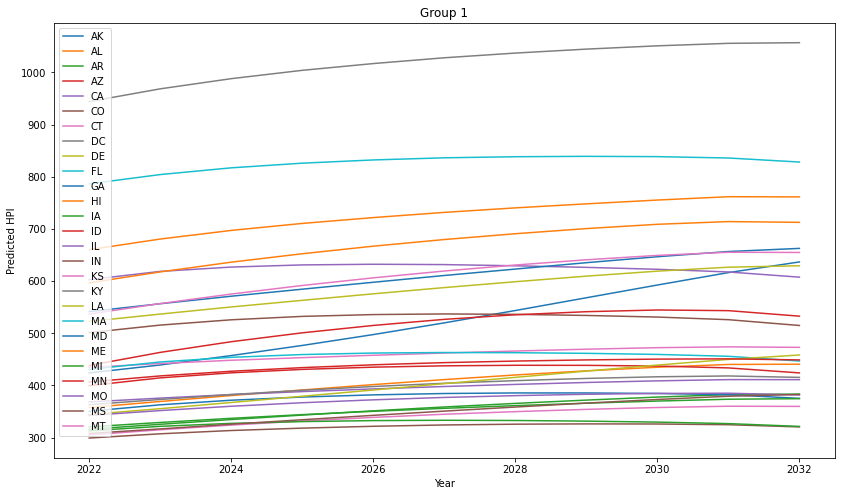

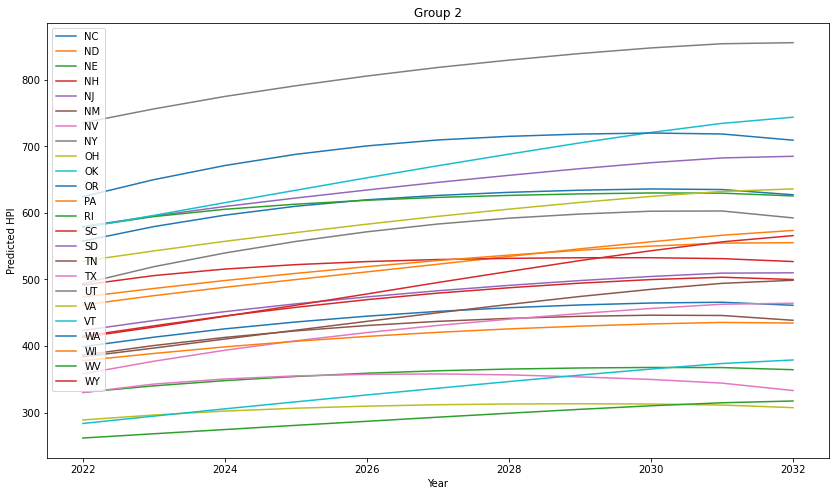

In [19]:
# Split predictions dataframe into two based on first letter of place_id
group_1 = pred_df[pred_df['place_id'].str[0] < 'N']
group_2 = pred_df[pred_df['place_id'].str[0] >= 'N']

# Create a line plot for each state in group 1
fig, ax = plt.subplots(figsize=(14, 8))
for state in group_1['place_id'].unique():
    data = group_1[group_1['place_id'] == state]
    ax.plot(data['yr'], data['predicted_index_nsa'], label=state)
ax.set_xlabel('Year')
ax.set_ylabel('Predicted HPI')
ax.set_title('Group 1')
ax.legend()

# Create a line plot for each state in group 2
fig, ax = plt.subplots(figsize=(14, 8))
for state in group_2['place_id'].unique():
    data = group_2[group_2['place_id'] == state]
    ax.plot(data['yr'], data['predicted_index_nsa'], label=state)
ax.set_xlabel('Year')
ax.set_ylabel('Predicted HPI')
ax.set_title('Group 2')
ax.legend()

The data shown within these graphs is overly optimistic.  The expectation of these predictions express that the values for all states will always essentially go up with a minor dip around 2032.  With that expectation, 2023 doesn't make sense in regards to housing prices and invalidates the entire set. 